<a href="https://colab.research.google.com/github/GeomaticsCaminosUPM/GeoVisionDataset/blob/main/examples/costa_rica_buildings_dataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Santo Domingo Building Footprint Dataset

A tutorial to create an instance segmentation dataset for building footprints in Santo Domingo (Dominican Republic).

Colab commands for library instalation

In [1]:
#Only execute this cell if you are using google colab
!pip install geopandas
!pip install git+https://github.com/GeomaticsCaminosUPM/GeoVisionDataset.git
!pip install folium matplotlib mapclassify
!pip install ipyleaflet
# After this restart the session

  Cloning https://github.com/GeomaticsCaminosUPM/GeoVisionDataset.git to /tmp/pip-req-build-tinzwbsj
  Running command git clone --filter=blob:none --quiet https://github.com/GeomaticsCaminosUPM/GeoVisionDataset.git /tmp/pip-req-build-tinzwbsj
  Resolved https://github.com/GeomaticsCaminosUPM/GeoVisionDataset.git to commit abb539d23a1dc5bfb76d3a2053669cecf629fb64
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for GeoVisionDataset: filename=geovisiondataset-0.1.0-py3-none-any.whl size=39686 sha256=52c5a044cf8112f41cc355cb175fee602b6f3a2147f39fb7d705df8ebb43342c
  Stored in directory: /tmp/pip-ephem-wheel-cache-7tgf4xep/wheels/db/bc/93/0b232dc505c6ba44cfa6d34958320668bb43b07319d4264317
Successfully built GeoVisionDataset


In [39]:
import geopandas as gpd
import shapely
from GeoVisionDataset import GeoDataset, ImageData, AnnotationData
from GeoVisionDataset.grid import Grid
import GeoVisionDataset.wms
import GeoVisionDataset.image
import GeoVisionDataset.annotation

## Data download

For this dataset we will use manually digitalized building footprints

In [40]:
#!curl -L -o footprints.gpkg https://github.com/GeomaticsCaminosUPM/footprint_attributes/raw/refs/heads/main/examples/footprints.gpkg

In [41]:
footprints_gdf_orig = gpd.read_file('footprints_santo_domingo.gpkg')
footprints_gdf_orig = footprints_gdf_orig.explode().reset_index() # Convert multipart to single part geometry

In [42]:
import geopandas as gpd
from shapely.ops import unary_union
import networkx as nx
from itertools import combinations

def build_merge_graph(gdf, threshold_ratio=0.1):
    """Builds a graph of polygons to merge based on shared boundary length."""
    G = nx.Graph()
    for idx in gdf.index:
        G.add_node(idx)

    for i, j in combinations(gdf.index, 2):
        geom_i = gdf.at[i, 'geometry']
        geom_j = gdf.at[j, 'geometry']
        
        if geom_i.intersects(geom_j):
            shared_length = geom_i.intersection(geom_j.exterior).length
            min_perimeter = min(geom_i.exterior.length,geom_j.exterior.length)
            max_perimeter = max(geom_i.exterior.length,geom_j.exterior.length)
            perimeter = min_perimeter*0.75+max_perimeter*0.25
            if shared_length / perimeter >= threshold_ratio:
                G.add_edge(i, j)

    return list(nx.connected_components(G))

def merge_group(gdf, group):
    """Merges a group of geometries."""
    return unary_union(gdf.loc[list(group), 'geometry'])

def merge_touching_polygons(gdf, threshold_ratio=0.1, buffer=0.05):
    gdf = gdf.copy()
    if type(gdf) is gpd.GeoSeries:
        gdf = gpd.GeoDataFrame({},geometry=gdf,crs=gdf.crs)
    # Ensure the geometries are in a projected CRS for accurate area and length calculations
    if not gdf.crs.is_projected:
        gdf = gdf.to_crs(gdf.geometry.estimate_utm_crs())

    gdf.geometry = gdf.geometry.buffer(
        distance=buffer,
        #cap_style='square',     # mostly affects LineStrings
        #join_style='mitre',     # sharp corners
        #mitre_limit=10
    )
    """Merges polygons with a significant shared boundary."""
    gdf = gdf.copy()
    groups = build_merge_graph(gdf, threshold_ratio)

    # Merge all geometries for each group
    merged_geometries = gpd.GeoSeries([merge_group(gdf, group) for group in groups],crs=gdf.crs)

    merged_geometries = merged_geometries.buffer(
        distance=-buffer,
        #cap_style='square',     # mostly affects LineStrings
        #join_style='mitre',     # sharp corners
        #mitre_limit=10
    )
    # Return a new GeoDataFrame
    return gpd.GeoDataFrame(geometry=merged_geometries, crs=gdf.crs)

footprints_gdf = merge_touching_polygons(footprints_gdf_orig, threshold_ratio=0.15,buffer=0.6)

In [43]:
footprints_gdf.explore()

## Dataset Bounds

The dataset bounds will be the bounds (convex hull) of the digitalized area.

In [44]:
dataset_bounds = gpd.GeoSeries(
    shapely.convex_hull(footprints_gdf.union_all()),
    crs=footprints_gdf.crs
)

## Dataset Grid

The library automatically generates a grid within the dataset bounds, dividing the area into image tiles with the appropriate size for your model.

### Configuration Parameters

You can customize the grid creation with the following parameters:

- **Image Resolution**:  
  The resolution of each image tile in meters per pixel


- **Image Shape**:  
  Defines the shape of each tile in pixels (width, height)


- **Tile Overlap**:  
  Specifies the overlap between adjacent tiles, expressed as a percentage of the tile size.
  

- **Tile in Dataset**:  
  Sets the minimum percentage of each tile that must be inside the dataset bounds to be considered valid.
  - **Tip**: If your segmentation or image data do not exist outside the dataset bounds, set this parameter to `1` or enable `hide_outside=True` when creating the dataset object.




#### Notes
- The grid generation process ensures that your dataset is divided into manageable tiles, optimized for your model input.



In [45]:
img_resolution = (0.3, 0.3)  # 15 cm per pixel (width, height)
img_shape = (512, 512)  # Image shape in pixels (width, height)
tile_overlap = 0.25  # 25% overlap on each side of the grid tiles
tile_in_dataset = 0.6  # 75% of the tile has to be inside the dataset bounds

In [46]:
grid = Grid(
    dataset_bounds=dataset_bounds,  # Define the dataset bounds
    resolution=img_resolution,      # Define the image resolution (meters per pixel)
    shape=img_shape,                # Define the image shape (pixels)
    overlap=tile_overlap,                # Set the overlap between tiles
    tile_in_dataset=tile_in_dataset # Set the minimum tile coverage within bounds
)

## **Images**  

The input data for an image segmentation geodataset consists of **RGB images**.

To prepare the dataset, we will use a custom ortophoto from a drone flight.

In [47]:
img_path = '/home/miguel/Documents/Proyectos/SismicaUPM/instance_segmentation/dataset/santo_domingo_orto.tif'

### Image provider object

The image provider object has the method handles requests and crops the image to the desired bounds and resolution.

In [48]:
img_obj = GeoVisionDataset.image.from_files(img_path)

## Annotations

In a geoimage segmentation dataset, the ground truth data consists of polygons representing objects, with each polygon assigned an ID corresponding to its semantic class.

Now, we can create our segmentation ground truth provider object.  

We only have one class and the instances are defined by the `shapely` polygons from the `footprints_gdf` file loaded previously.

In [49]:
ann_obj = GeoVisionDataset.annotation.Polygon(footprints_gdf,semantic_class=1)

## Dataset object

We can now create a `GeoVisionDataset` object by inputting the image and segmentation providers.

- `instances=True` as our dataset is an instance segmentation dataset
- `hide_outside=True` as the segmentation provider can only provide information inside the dataset bounds and we do not want any unmarked building appearing in the image

In [50]:
ds = GeoDataset(
    grid=grid,
    image=img_obj,
    annotation=ann_obj,
    hide_outside=True,
    n_classes=1,
    min_area=0,
    min_object_coverage=0,#0.05,
    min_tile_coverage=0,#0.05,
    instances=True
)

Let's take a look at the dataset bounds and tiles

In [51]:
ds.to_map(mode='grid')

### Image, Segmentation, and Grid on a Map

We can visualize specific tiles (e.g., tiles `0`, `1`, and `2`) on a map, including their image, segmentation, and grid boundaries or the whole dataset as in this example.  

### Important Notes  

- **Segmentation Geometries:**  
  Plotting segmentation geometries can be computationally intensive, especially for large datasets.  
  - **Tip:** Avoid plotting the entire dataset at once.  
  - Instead, provide:  
    - A **list of specific tile IDs** (e.g., `[0, 1, 2]`), or  
    - A **GeoSeries Polygon geometry** to indicate the region of the dataset to be plotted.  


In [31]:
ds.to_map(bounds=dataset_bounds,mode='all')

/home/miguel/python_envs/seismic_building_exposure/lib/python3.12/site-packages/GeoVisionDataset/geodataset.py:372: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  m=geometry[geometry['semantic_class'] == 0].explore(m=m,color='black',legend=False)


KeyboardInterrupt: 

### Plotting one Tile

To visualize tile `0`, you can specify the `ann_mode` to define the annotation format.
This represents exactly how the tile of the dataset will look like.

The supported formats are:  

- **`coco`:** COCO annotation format.  
- **`raster`:** Two raster files (semantic and instance classes).  
- **`geodataframe`:** Geometries as a GeoDataFrame.  
- **`maskformer`:** 3-channel image format used by MaskFormer.  

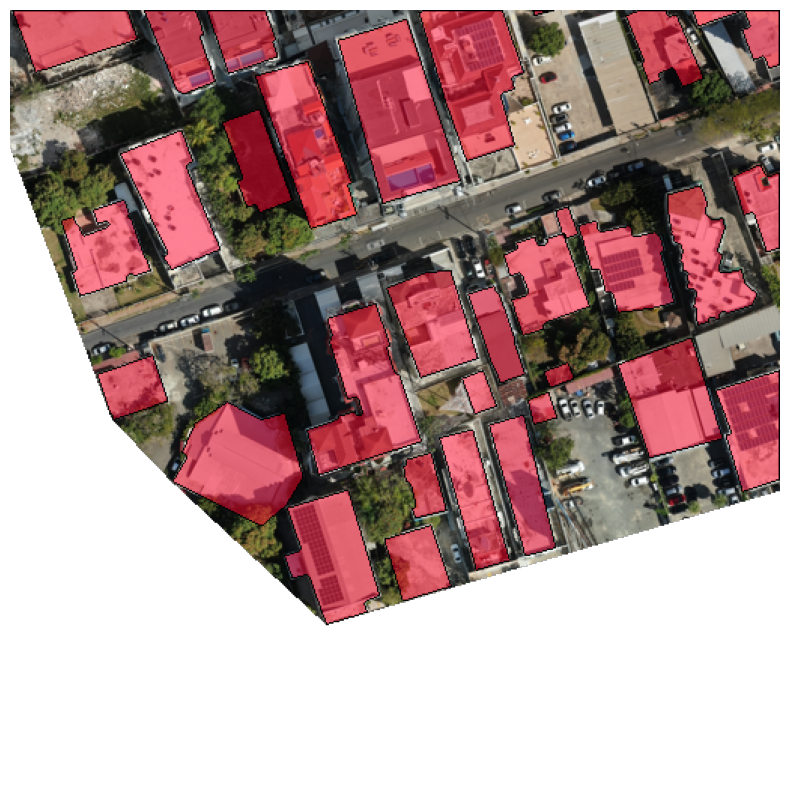

In [52]:
ds.plot(4,ann_mode='coco')

### Accessing Images and Annotations  

You can access images and annotations for a specific tile using the `get_image` and `get_annotation` methods. These methods allow you to retrieve data by:  

1. **Providing the Tile ID:**  
   - Specify the unique ID of the tile.  
2. **Providing a Polygon Geometry:**  
   - Pass a `GeoSeries` Polygon geometry to retrieve data for a specific region.  

In [53]:
img,img_bounds = ds.get_image(0)

In [54]:
coco,seg_bounds = ds.get_annotation(0,ann_mode='coco',bounds=img_bounds)

gdf,seg_bounds = ds.get_annotation(0,ann_mode='geodataframe',bounds=img_bounds)

semantic,seg_bounds = ds.get_annotation(0,ann_mode='raster',bounds=img_bounds)

maskformer,seg_bounds = ds.get_annotation(0,ann_mode='maskformer',bounds=img_bounds)

### Downloading the Dataset  

Before downloading the dataset, you need to select the tiles that you want to download. You can choose the tiles using one of the following methods:

### Methods for Selecting Tiles

1. **Select All Tiles:**

   Use `select_all_tiles()` to select every tile in the dataset.


2. **Select Random Tiles:**

   Use `select_random_tiles(n_tiles)` to randomly select a specified number of tiles (`n_tiles`).


3. **Select Tiles by ID List:**

   Use `select_tiles(tile_id_list)` to select specific tiles by their tile IDs.


4. **Select Tiles within Specific Bounds:**

   Use `select_tiles_in_bounds(bounds:gpd.GeoSeries, how='intersects' or 'contains')` to select tiles based on geographical bounds. You can specify the selection type:
   - `'intersects'`: Select tiles that intersect with the provided bounds.
   - `'contains'`: Select tiles fully contained within the provided bounds.


#### Notes  
- After selecting the tiles, use the `download()` method to save the images and annotations in the desired format.  


In [55]:
ds.select_all_tiles()

To download the entire dataset, you need to specify the **download paths** and the **annotation format**. In addition, the following parameters are available for customization:

### Parameters  

- **`img_path`:**  
  The path where the images will be saved.  

- **`anns_path`:**  
  The paths where the annotations will be saved.  

- **`ann_mode`:**  
  The annotation format (e.g., `'coco'`, `'raster'`, `'geodataframe'`, `'maskformer'`).

- **`on_errors`** (default: `'ignore'`):  
  Defines the behavior when an error occurs for an image or segmentation provider:
  - `'ignore'`: Skip the tile and continue.
  - `'raise'`: Stop processing when an error occurs and raise it.

- **`overwrite`** (default: `False`):  
  If set to `True`, any existing files will be overwritten.  

- **`allow_empty_anns`** (default: `False`):  
  Specifies whether to allow tiles with no objects in the annotations:
  - `'False'`: Skip the tile if no objects are found (recommended for training).
  - `'True'`: Save the tile even if no objects are present (useful for validation datasets).  


In [56]:
ds.download(img_path='SantoDomingo_30cm_agg/images',anns_path='SantoDomingo_30cm_agg',ann_mode='coco',allow_empty_anns=False)

Progress: [######] 100% (61/61)Grid tiles saved as SantoDomingo_30cm_agg/images/grid_tiles.geojson
Grid bounds saved as SantoDomingo_30cm_agg/images/grid_bounds.geojson
Dataset bounds saved as SantoDomingo_30cm_agg/images/dataset_bounds.geojson
Grid tiles saved as SantoDomingo_30cm_agg/grid_tiles.geojson
Grid bounds saved as SantoDomingo_30cm_agg/grid_bounds.geojson
Dataset bounds saved as SantoDomingo_30cm_agg/dataset_bounds.geojson
polygons saved as SantoDomingo_30cm_agg/anns_metadata_0_polygons.geojson
